In [51]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [52]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [53]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [54]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [94]:
# rename the column so that it's easier to evaluate them later
column_names = {
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
}
df = df.rename(columns= column_names)

# EDA

In [56]:
# Inspect data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BGlucose   599 non-null    int64  
 1   B1         599 non-null    int64  
 2   BPressure  599 non-null    int64  
 3   B2         599 non-null    int64  
 4   B3         599 non-null    int64  
 5   BMI        599 non-null    float64
 6   B4         599 non-null    float64
 7   Age        599 non-null    int64  
 8   Sepssis    599 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 42.2+ KB


In [57]:
pd.isna(df).sum()

BGlucose     0
B1           0
BPressure    0
B2           0
B3           0
BMI          0
B4           0
Age          0
Sepssis      0
dtype: int64

In [58]:
df.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [59]:
def print_no_0(df):
    for col in df.columns:
        print(f"{col}: {df[col].isin([0]).sum()}")


# Preprocessing

## Spliting depedent and independent variables

In [60]:
X = df.drop(columns="Sepssis")
X = X.reset_index(drop=True)

Y = df[['Sepssis']]

print(X.shape)
print(Y.shape)

(599, 8)
(599, 1)


In [61]:
# Encode target value

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y.values.ravel())


print(Y[:5])

[1 0 1 0 1]


## Outliers

In [62]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    print(f"{col} - 1tile: {percentiles[0]} - 99tile: {percentiles[1]}")
    X[col] = np.clip(X[col], percentiles[0], percentiles[1])

BGlucose - 1tile: 0.0 - 99tile: 13.0
B1 - 1tile: 56.74000000000001 - 99tile: 196.0
BPressure - 1tile: 0.0 - 99tile: 104.07999999999993
B2 - 1tile: 0.0 - 99tile: 52.039999999999964
B3 - 1tile: 0.0 - 99tile: 543.04
BMI - 1tile: 0.0 - 99tile: 52.3
B4 - 1tile: 0.08897999999999999 - 99tile: 1.731999999999999
Age - 1tile: 21.0 - 99tile: 66.01999999999998


In [63]:
# After capping outliers, how many zero do we have left?
print_no_0(X)

BGlucose: 93
B1: 0
BPressure: 28
B2: 175
B3: 289
BMI: 9
B4: 0
Age: 0


We successfully remove outliers 0 of B1. However there are still weird 0 in BMI so, we will try to imput those missing value using K-NN.

In [64]:
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

X["BMI"].replace({0:np.nan}, inplace=True)

imputer = KNNImputer(n_neighbors=23,)


X_imput = imputer.fit_transform(X)
X = pd.DataFrame(X_imput, columns=["BGlucose","B1","BPressure", "B2", "B3", "BMI","B4", "Age"])


In [65]:
X.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.811352,120.638464,68.660234,20.439466,78.232454,32.328054,0.477130,33.245609
std,3.320576,31.245890,19.182127,15.644498,110.398214,6.817732,0.318419,11.683879
min,0.000000,56.740000,0.000000,0.000000,0.000000,18.200000,0.088980,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.400000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000
max,13.000000,196.000000,104.080000,52.040000,543.040000,52.300000,1.732000,66.020000


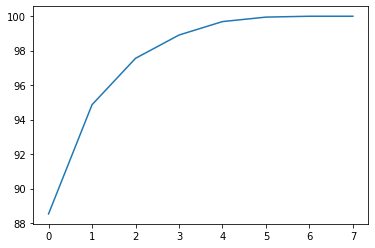

In [17]:
from sklearn.decomposition import PCA
# df["Sepssis"] = np.where(df["Sepssis"].str.contains("Positive"), 1, 0)
pca = PCA(n_components=8)
pca.fit(X)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

# Models Development

**Miscelleous codes**

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline as ImPipeline

In [67]:
def draw_confusion_matrix(cnf_matrix):
    class_names=["Positive","Negative"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
def print_evaluate_score(y_test, y_pred):
    cnf = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    draw_confusion_matrix(cnf)

In [49]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedKFold, cross_validate

from sklearn import model_selection
def print_cross_validate(model):
    scoring = {
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

    kfold = RepeatedKFold(n_splits=8, n_repeats=5, random_state=42)

    results = cross_validate(estimator=model,
                                            X=X,
                                            y=Y,
                                            cv=kfold,
                                            scoring=scoring, return_train_score=False)
                                            
    print("F1-score: %.3f"%results["test_f1_score"].mean())
    print("Precision score: %.3f"%results["test_precision"].mean())
    print("Recall score: %.3f"%results["test_recall"].mean())

In [22]:
from sklearn.metrics import roc_curve
def plot_roc_curve(test_y,model_probs):

	# plot model roc curve
	fpr, tpr, _ = roc_curve(test_y, model_probs)
	plt.plot(fpr, tpr, marker='.', label='Logistic')
	# axis labels
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	# show the legend
	plt.legend()
	# show the plot
	plt.show()

In [23]:
from sklearn.metrics import confusion_matrix,f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


def print_hold_out_evaluation(model, X, Y):
# spliting
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=6, test_size=0.2)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print_evaluate_score(y_test, pred)
    propa = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, propa)
    print('Model AUC score: %.3f' % roc_auc)
    # plot roc curves
    plot_roc_curve(y_test, propa)



## 1. Logistic Regression

From the EDA phase we have learned that there is no linear relationship exists among the features we used to train our model; therefore, I will use a polynomial logistic regression. And because we use polynomial features, we can't underestimate the chance of overfitting, I will also use regularization technique to overcome that problem.

I designed baseline logistic regression model:
- solver="liblinear"
    - it's because this algorithm works best for a small dataset
- class-weight="balanced"
    - It's an attempt to compensate the imblanced issue of the training dataset
- penalty="l2"
    - It's because feature selection is not neccessary for this dataset


In [68]:
# use polynomial to improve model fitting
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
poly = PolynomialFeatures(degree=1)

# instantiate the model (using the default parameters)
solver = "liblinear"
lr_model = LogisticRegression(C=1, solver= solver, 
max_iter=7000, tol=1e-3,
penalty="l2", random_state=4)

scaler = RobustScaler()

lr_pipe = Pipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])

In [69]:
# SearchGrid CV
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
param_grid = {
    "logistic__C":np.logspace(-1, 1, 10),
    # "logistic__penalty":["l1","l2"],
    "poly__degree":[2,3,4]

}
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)
search = GridSearchCV(lr_pipe, param_grid, scoring="f1_micro",cv=cv)
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.772):
{'logistic__C': 0.46415888336127786, 'poly__degree': 2}


In [70]:
print("Grid scores on development set:")
print()
# print(search.cv_results_)
means = search.cv_results_["mean_test_score"]
stds = search.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, search.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Grid scores on development set:

0.769 (+/-0.064) for {'logistic__C': 0.1, 'poly__degree': 2}
0.767 (+/-0.062) for {'logistic__C': 0.1, 'poly__degree': 3}
0.747 (+/-0.069) for {'logistic__C': 0.1, 'poly__degree': 4}
0.769 (+/-0.061) for {'logistic__C': 0.16681005372000587, 'poly__degree': 2}
0.762 (+/-0.061) for {'logistic__C': 0.16681005372000587, 'poly__degree': 3}
0.744 (+/-0.070) for {'logistic__C': 0.16681005372000587, 'poly__degree': 4}
0.768 (+/-0.066) for {'logistic__C': 0.2782559402207124, 'poly__degree': 2}
0.754 (+/-0.060) for {'logistic__C': 0.2782559402207124, 'poly__degree': 3}
0.737 (+/-0.069) for {'logistic__C': 0.2782559402207124, 'poly__degree': 4}
0.772 (+/-0.068) for {'logistic__C': 0.46415888336127786, 'poly__degree': 2}
0.752 (+/-0.065) for {'logistic__C': 0.46415888336127786, 'poly__degree': 3}
0.734 (+/-0.079) for {'logistic__C': 0.46415888336127786, 'poly__degree': 4}
0.770 (+/-0.066) for {'logistic__C': 0.774263682681127, 'poly__degree': 2}
0.743 (+/-0.061) fo

In [42]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.46415888336127786_2,"{'logistic__C': 0.46415888336127786, 'poly__de...",1,0.771258,0.034402
0.16681005372000587_2,"{'logistic__C': 0.16681005372000587, 'poly__de...",2,0.769927,0.031300
0.1_2,"{'logistic__C': 0.1, 'poly__degree': 2}",3,0.769602,0.030849
0.2782559402207124_2,"{'logistic__C': 0.2782559402207124, 'poly__deg...",4,0.768919,0.033891
1.291549665014884_2,"{'logistic__C': 1.291549665014884, 'poly__degr...",5,0.768591,0.033094
0.774263682681127_2,"{'logistic__C': 0.774263682681127, 'poly__degr...",6,0.767919,0.034155
0.1_3,"{'logistic__C': 0.1, 'poly__degree': 3}",7,0.767896,0.031970
2.1544346900318834_2,"{'logistic__C': 2.1544346900318834, 'poly__deg...",8,0.767585,0.031757
3.593813663804626_2,"{'logistic__C': 3.593813663804626, 'poly__degr...",9,0.763588,0.032713


In [89]:
# logistic__C = search.best_params_["logistic__C"]
# logistic__class_weight = search.best_params_["logistic__class_weight"]
# logistic__penalty = search.best_params_["logistic__penalty"]
# poly_degree = search.best_params_["poly__degree"]
# best_logisticReg = LogisticRegression(
#     penalty= logistic__penalty,
#     C= logistic__C,
#     class_weight=logistic__class_weight,
#     random_state=4,
#     solver= solver,
#     max_iter=7000
# )
# poly = PolynomialFeatures(degree=poly_degree)

best_logisticReg = LogisticRegression(
    penalty= "l2",
    C=0.46415888336127786,
    random_state=4,
    solver= solver,
    max_iter=7000
)
poly = PolynomialFeatures(degree=2)
print(best_logisticReg)

LogisticRegression(C=0.46415888336127786, max_iter=7000, random_state=4,
                   solver='liblinear')


In [87]:
best_logistic_pipe = Pipeline(steps=[("poly",poly),("scaler", scaler), ("model",best_logisticReg)])

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        81
           1       0.65      0.62      0.63        39

    accuracy                           0.77       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.76      0.77      0.77       120



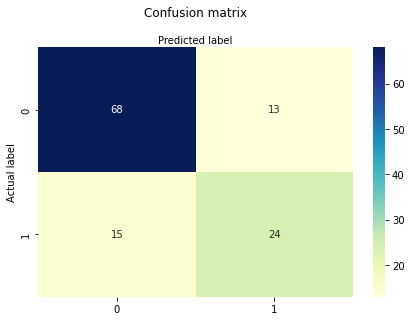

Model AUC score: 0.846


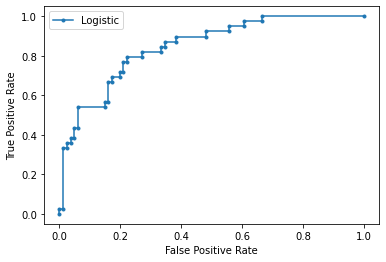

In [45]:
print_hold_out_evaluation(best_logistic_pipe, X, Y)

In [50]:
print_cross_validate(best_logistic_pipe)


F1-score: 0.617
Precision score: 0.708
Recall score: 0.555


## 2. Decision Tree

In [141]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline


dtree_model = DecisionTreeClassifier(max_features="sqrt", random_state=4, ccp_alpha=0.0032, min_samples_split=2)
steps = [('model', dtree_model)]
dtree_pipe = Pipeline(steps=steps)

In [37]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    # "model__class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "model__class_weight": ["balanced", {0:0.4,1:0.6}, {0:0.5,1:0.5}],
    "model__ccp_alpha": np.logspace(-3,1,10),
    "model__max_depth": [2,3,4],
    "model__min_samples_leaf": [1,2,3,4,5],
    "model__min_samples_split": [2,3,4,5],

}
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)
search = GridSearchCV(dtree_pipe, param_grid, scoring="f1_micro",cv=cv, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.717):
{'model__ccp_alpha': 0.001, 'model__class_weight': {0: 0.5, 1: 0.5}, 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2}


In [142]:
# b_params = search.best_params_
# model__class_weight = b_params["model__class_weight"]
# model__ccp_alpha = b_params["model__ccp_alpha"]
# model__max_depth = b_params["model__max_depth"]
# model__min_samples_leaf = b_params["model__min_samples_leaf"]

# dtree_model = DecisionTreeClassifier(max_features="sqrt",
# class_weight=model__class_weight, 
# random_state=4, 
# ccp_alpha=model__ccp_alpha,
# max_depth=model__max_depth,
# min_samples_leaf=model__min_samples_leaf)

dtree_model = DecisionTreeClassifier(max_features="sqrt",
class_weight={0: 0.5, 1: 0.5}, 
random_state=4, 
ccp_alpha=0.001,
max_depth=4,
min_samples_leaf=4,
min_samples_split=2)

steps = [('model', dtree_model)]

dtree_pipe = Pipeline(steps=steps)


              precision    recall  f1-score   support

           0       0.83      0.85      0.84        81
           1       0.68      0.64      0.66        39

    accuracy                           0.78       120
   macro avg       0.75      0.75      0.75       120
weighted avg       0.78      0.78      0.78       120



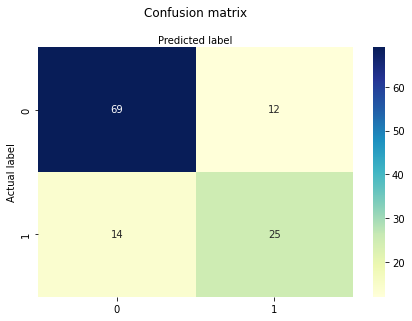

In [39]:
print_hold_out_evaluation(dtree_pipe, X, Y)

In [40]:
print_cross_validate(dtree_pipe)

F1-score: 0.552
Accuracy score: 0.705
Recall score: 0.536


## 4. Random Forest

In [134]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(max_features="sqrt",random_state=3,class_weight={0:0.22, 1: 0.78}, n_jobs=-1)

In [46]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [100,150,200],
    # "class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "class_weight": ["balanced"],
    "ccp_alpha": np.logspace(-3,1,5),
    "max_depth": [2,3,4],
    "min_samples_split": [2,3,4,5]

}
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=4)
search = GridSearchCV(rf_model, param_grid, scoring="f1_micro",cv=5, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.765):
{'ccp_alpha': 0.01, 'class_weight': 'balanced', 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 150}


In [135]:
# b_params = search.best_params_
# n_estimators = b_params["n_estimators"]
# class_weight = b_params["class_weight"]
# ccp_alpha = b_params["ccp_alpha"]
# max_depth = b_params["max_depth"]
# min_samples_leaf = b_params["min_samples_leaf"]
# min_samples_split = b_params["min_samples_split"]

# rf_model = RandomForestClassifier(max_features="sqrt",
#                             random_state=3,
#                             class_weight=class_weight, 
#                             ccp_alpha= ccp_alpha,
#                             max_depth= max_depth,
#                             min_samples_leaf= min_samples_leaf,
#                             min_samples_split= min_samples_split,
#                             n_jobs=-1)

rf_model = RandomForestClassifier(
                            max_features="sqrt",
                            random_state=3,
                            n_estimators=150,
                            class_weight="balanced", 
                            ccp_alpha= 0.01,
                            max_depth= 4,
                            min_samples_split= 5,
                            n_jobs=-1)

              precision    recall  f1-score   support

           0       0.86      0.74      0.79        81
           1       0.58      0.74      0.65        39

    accuracy                           0.74       120
   macro avg       0.72      0.74      0.72       120
weighted avg       0.77      0.74      0.75       120



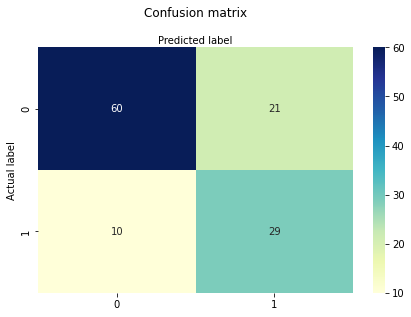

In [53]:
print_hold_out_evaluation(rf_model, X, Y)


In [54]:
print_cross_validate(rf_model)

F1-score: 0.675
Precision score: 0.620
Recall score: 0.749


## 5. Boosting


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.5, max_depth=1, random_state=0, tol=0.001)


In [41]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
param_grid = {
    "n_estimators": [100,200, 150],
    "max_depth": [1,2,3],
    "ccp_alpha": np.logspace(-3,1,10),
    "max_features": ["sqrt"],
    "min_samples_split": [2,3],

}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=4)
search = GridSearchCV(clf, param_grid, scoring="roc_auc",cv=10, error_score="raise")
search.fit(X, Y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.827):
{'ccp_alpha': 0.001, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


In [42]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("settings")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
settings,,,,
0.001_1_sqrt_2_100,"{'ccp_alpha': 0.001, 'max_depth': 1, 'max_feat...",1,0.827207,0.057899
0.001_1_sqrt_2_200,"{'ccp_alpha': 0.001, 'max_depth': 1, 'max_feat...",1,0.827207,0.057899
0.001_1_sqrt_2_150,"{'ccp_alpha': 0.001, 'max_depth': 1, 'max_feat...",1,0.827207,0.057899
0.001_1_sqrt_3_100,"{'ccp_alpha': 0.001, 'max_depth': 1, 'max_feat...",1,0.827207,0.057899
0.001_1_sqrt_3_200,"{'ccp_alpha': 0.001, 'max_depth': 1, 'max_feat...",1,0.827207,0.057899
...,...,...,...,...
1.0_1_sqrt_3_100,"{'ccp_alpha': 1.0, 'max_depth': 1, 'max_featur...",37,0.500000,0.000000
1.0_1_sqrt_3_200,"{'ccp_alpha': 1.0, 'max_depth': 1, 'max_featur...",37,0.500000,0.000000
1.0_1_sqrt_3_150,"{'ccp_alpha': 1.0, 'max_depth': 1, 'max_featur...",37,0.500000,0.000000


In [43]:
clf = GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.5, 
        max_depth=1, 
        random_state=0, 
        max_features="sqrt",
        min_samples_split=2,
        ccp_alpha=0.001,
        tol=0.001)


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        81
           1       0.62      0.67      0.64        39

    accuracy                           0.76       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.76      0.76      0.76       120



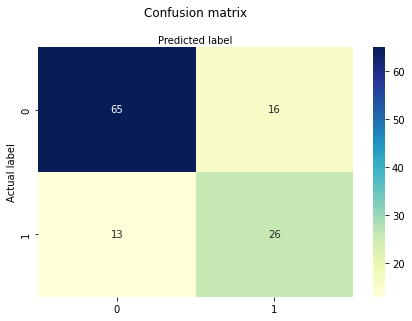

Logistic ROC AUC 0.853


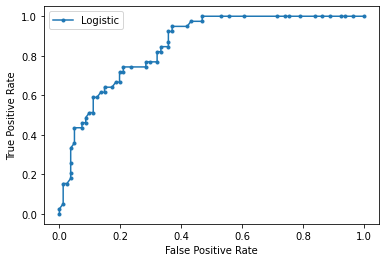

In [60]:
print_hold_out_evaluation(clf, X, Y)

In [45]:
print_cross_validate(clf)

F1-score: 0.609
Precision score: 0.699
Recall score: 0.550


# 3. Test Model

In [143]:
the_best = dtree_model

In [144]:
testset = pd.read_csv("Paitients_Files_Test.csv")
testset.rename(columns=column_names, inplace=True)
testset.head()

,ID,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0


In [145]:
id_col = testset["ID"]
testset.drop(columns=["ID","Insurance"], inplace=True)

In [146]:
the_best.fit(X, Y)


DecisionTreeClassifier(ccp_alpha=0.001, class_weight={0: 0.5, 1: 0.5},
                       max_depth=4, max_features='sqrt', min_samples_leaf=4,
                       random_state=4)

In [147]:
pred_test = the_best.predict(testset)

In [148]:
result_to_csv = pd.concat([id_col, pd.Series(pred_test)], axis=1)
result_to_csv

,ID,0
0,ICU200609,0
1,ICU200610,0
2,ICU200611,0
3,ICU200612,1
4,ICU200613,1
...,...,...
164,ICU200773,1
165,ICU200774,0
166,ICU200775,0
167,ICU200776,1


In [121]:
result_to_csv.to_csv("S3804803_predictions.csv")

In [149]:
result_to_csv.groupby(0).count()

,ID
0,
0,111
1,58
